# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_132  P02794                              15.304
Sample_094  O60888;O60888-2;O60888-3            18.408
Sample_182  P35749;P35749-2;P35749-3;P35749-4   21.850
Sample_104  Q8N2Q7;Q8N2Q7-2                     16.925
Sample_077  P08697                              19.062
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups 
Sample_025  O75636;O75636-2   15.439
Sample_110  P01912;Q5Y7A7     15.986
Sample_027  Q8NBJ4;Q8NBJ4-2   17.351
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.033
            A0A075B6Q5                 13.167
            A0A075B6R2                 14.328
            A0A075B6S5                 14.242
            A0A087WSY4                 12.051
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.763
            Q9UI40;Q9UI40-2            12.839
            Q9UIW2                     12.353
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.354
            Q9UP79                     13.841
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.382,15.050,16.842,19.863,15.827,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.407,19.067,...,15.528,15.576,14.028,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.812,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.824,17.705,17.039,15.615,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.949,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.597,15.345,17.084,18.708,14.249,19.433,11.901,10.712
Sample_207,15.739,16.877,15.469,16.898,13.377,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.033,...,16.012,15.178,13.629,15.050,16.842,19.863,13.560,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.957,19.067,16.188,...,15.528,15.576,12.807,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,11.267,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,14.052,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.758,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.789,15.345,17.084,18.708,14.249,19.433,12.519,12.902
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 391.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.37it/s]

100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.33it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.27it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.21it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.90it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.01it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.17it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.90it/s]

100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.25it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.86it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.35it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.21it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.10it/s]

100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

100%|██████████| 7/7 [00:03<00:00,  2.33it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.60it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.98it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.31it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.98it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.79it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.74it/s]

100%|██████████| 8/8 [00:03<00:00,  1.77it/s]

100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.58it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.50it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.27it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.10it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.27it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.94it/s]

 30%|███       | 3/10 [00:00<00:01,  3.53it/s]

 40%|████      | 4/10 [00:01<00:02,  2.68it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.26it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.16it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.30it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.94it/s]

100%|██████████| 10/10 [00:04<00:00,  1.90it/s]

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.35it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.86it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.49it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.13it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.82it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.74it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.78it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.86it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.95it/s]

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.81it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.52it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.16it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.86it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.84it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.95it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.97it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.09it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.48it/s]

100%|██████████| 12/12 [00:05<00:00,  2.40it/s]

100%|██████████| 12/12 [00:05<00:00,  2.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.92it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.04it/s]

 31%|███       | 4/13 [00:01<00:02,  3.33it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.85it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.13it/s]

 54%|█████▍    | 7/13 [00:02<00:03,  1.89it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.87it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.96it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.18it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.33it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.37it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.13it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.64it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.25it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.02it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.43it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.15it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.06it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.08it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.23it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.44it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.52it/s]

100%|██████████| 14/14 [00:05<00:00,  2.31it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.26it/s]

 20%|██        | 3/15 [00:00<00:02,  4.10it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.31it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.90it/s]

 40%|████      | 6/15 [00:01<00:03,  2.59it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.13it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.98it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.87it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.84it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.98it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.06it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  2.00it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.08it/s]

100%|██████████| 15/15 [00:06<00:00,  2.14it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.069 0.027          0.731 0.385       0.111   
2             0.006 0.005      0.079 0.026          0.752 0.085       0.706   
3             0.006 0.005      0.070 0.026          0.771 0.097       0.715   
4             0.006 0.006      0.072 0.025          0.784 0.097       0.790   
5             0.007 0.006      0.081 0.028          0.771 0.092       0.786   
6             0.006 0.006      0.063 0.025          0.817 0.086       0.813   
7             0.007 0.008      0.074 0.029          0.832 0.084       0.815   
8             0.006 0.004      0.062 0.023          0.827 0.084       0.810   
9             0.007 0.005      0.079 0.029          0.827 0.086       0.809   
10            0.007 0.005      0.072 0.029          0.828 0.092       0.804   
11            0.007 0.005      0.072 0.022          0.819 0.090       0.803   
12            0.005 0.003      0.068 0.027          0.806 0.090       0.807   
13            0.008 0.007      0.085 0.043          0.803 0.090       0.802   
14            0.009 0.006      0.094 0.032          0.820 0.080       0.796   
15            0.007 0.006      0.075 0.030          0.822 0.078       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.186 0.133                  0.548 0.043        0.857   
2          0.094   0.722 0.062                  0.764 0.048        0.865   
3          0.089   0.736 0.066                  0.776 0.054        0.859   
4          0.097   0.782 0.072                  0.812 0.062        0.896   
5          0.092   0.774 0.066                  0.805 0.058        0.897   
6          0.097   0.810 0.067                  0.838 0.057        0.913   
7          0.098   0.819 0.068                  0.845 0.057        0.914   
8          0.098   0.813 0.066                  0.841 0.055        0.911   
9          0.097   0.813 0.065                  0.840 0.055        0.912   
10         0.095   0.810 0.066                  0.838 0.055        0.911   
11         0.092   0.806 0.068                  0.834 0.058        0.910   
12         0.092   0.802 0.067                  0.830 0.057        0.909   
13         0.091   0.798 0.068                  0.826 0.058        0.908   
14         0.088   0.804 0.065                  0.833 0.055        0.913   
15         0.091   0.807 0.065                  0.835 0.055        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.826 0.086        210.000 0.000  
2          0.051                  0.840 0.061        210.000 0.000  
3          0.055                  0.840 0.061        210.000 0.000  
4          0.050                  0.878 0.062        210.000 0.000  
5          0.046                  0.885 0.051        210.000 0.000  
6          0.044                  0.900 0.051        210.000 0.000  
7          0.046                  0.901 0.052        210.000 0.000  
8          0.047                  0.898 0.053        210.000 0.000  
9          0.047                  0.901 0.053        210.000 0.000  
10         0.047                  0.899 0.053        210.000 0.000  
11         0.048                  0.897 0.055        210.000 0.000  
12         0.048                  0.897 0.053        210.000 0.000  
13         0.049                  0.896 0.054        210.000 0.000  
14         0.047                  0.900 0.051        210.000 0.000  
15         0.047                  0.901 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 376.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.74it/s]

100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.64it/s]

100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.70it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.89it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.29it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.36it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.63it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.39it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.04it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.00it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.46it/s]

100%|██████████| 7/7 [00:02<00:00,  2.16it/s]

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.96it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.25it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.64it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.56it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.98it/s]

100%|██████████| 8/8 [00:03<00:00,  1.98it/s]

100%|██████████| 8/8 [00:03<00:00,  2.30it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.70it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.43it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.10it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.77it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.67it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.31it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.05it/s]

100%|██████████| 9/9 [00:03<00:00,  1.94it/s]

100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.56it/s]

 30%|███       | 3/10 [00:00<00:02,  3.19it/s]

 40%|████      | 4/10 [00:01<00:02,  2.86it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.60it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.35it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.98it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.86it/s]

100%|██████████| 10/10 [00:04<00:00,  1.81it/s]

100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.38it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.30it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.87it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.76it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.33it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.28it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.05it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.05it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.11it/s]

100%|██████████| 11/11 [00:04<00:00,  1.97it/s]

100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.52it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.17it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.78it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.69it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.41it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.31it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.06it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.87it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.89it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.89it/s]

100%|██████████| 12/12 [00:05<00:00,  1.94it/s]

100%|██████████| 12/12 [00:05<00:00,  2.19it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.63it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.42it/s]

 31%|███       | 4/13 [00:01<00:03,  2.77it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.78it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.31it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.41it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.34it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.31it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.04it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.86it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.87it/s]

100%|██████████| 13/13 [00:05<00:00,  1.88it/s]

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.91it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.12it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.77it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.43it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.34it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.26it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.23it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.22it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.88it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.74it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.66it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.76it/s]

100%|██████████| 14/14 [00:06<00:00,  1.86it/s]

100%|██████████| 14/14 [00:06<00:00,  2.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.39it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.65it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.51it/s]

 40%|████      | 6/15 [00:02<00:03,  2.33it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.27it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.32it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.33it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.91it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.80it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.76it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.77it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.90it/s]

100%|██████████| 15/15 [00:06<00:00,  1.97it/s]

100%|██████████| 15/15 [00:07<00:00,  2.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.099 0.049          0.157 0.328       0.019   
2             0.007 0.006      0.083 0.032          0.614 0.100       0.525   
3             0.007 0.006      0.096 0.040          0.828 0.088       0.731   
4             0.008 0.008      0.103 0.045          0.818 0.100       0.741   
5             0.006 0.005      0.080 0.032          0.817 0.096       0.747   
6             0.007 0.005      0.093 0.035          0.810 0.092       0.783   
7             0.009 0.007      0.099 0.039          0.810 0.094       0.786   
8             0.005 0.004      0.070 0.029          0.811 0.092       0.782   
9             0.005 0.004      0.065 0.032          0.804 0.095       0.787   
10            0.005 0.003      0.076 0.031          0.799 0.099       0.778   
11            0.006 0.004      0.071 0.027          0.793 0.092       0.801   
12            0.005 0.003      0.059 0.020          0.817 0.085       0.834   
13            0.006 0.005      0.062 0.020          0.816 0.085       0.828   
14            0.006 0.006      0.057 0.018          0.820 0.089       0.816   
15            0.004 0.000      0.062 0.022          0.810 0.085       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.032 0.073                  0.504 0.019        0.874   
2          0.115   0.560 0.093                  0.641 0.066        0.745   
3          0.126   0.770 0.089                  0.809 0.069        0.881   
4          0.122   0.771 0.085                  0.807 0.068        0.883   
5          0.115   0.774 0.080                  0.809 0.064        0.880   
6          0.123   0.789 0.078                  0.822 0.064        0.911   
7          0.120   0.791 0.077                  0.823 0.064        0.908   
8          0.115   0.789 0.074                  0.821 0.062        0.905   
9          0.107   0.790 0.072                  0.820 0.060        0.903   
10         0.119   0.782 0.084                  0.815 0.069        0.910   
11         0.111   0.791 0.075                  0.821 0.065        0.914   
12         0.092   0.821 0.064                  0.846 0.056        0.926   
13         0.096   0.818 0.065                  0.844 0.056        0.925   
14         0.097   0.813 0.069                  0.840 0.059        0.927   
15         0.094   0.807 0.065                  0.835 0.056        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.838 0.087        210.000 0.000  
2          0.073                  0.682 0.097        210.000 0.000  
3          0.056                  0.860 0.069        210.000 0.000  
4          0.056                  0.863 0.067        210.000 0.000  
5          0.057                  0.859 0.068        210.000 0.000  
6          0.047                  0.894 0.058        210.000 0.000  
7          0.048                  0.892 0.058        210.000 0.000  
8          0.050                  0.889 0.060        210.000 0.000  
9          0.052                  0.889 0.062        210.000 0.000  
10         0.048                  0.895 0.055        210.000 0.000  
11         0.048                  0.901 0.055        210.000 0.000  
12         0.042                  0.917 0.048        210.000 0.000  
13         0.043                  0.915 0.049        210.000 0.000  
14         0.042                  0.915 0.048        210.000 0.000  
15         0.041                  0.914 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1014.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.49it/s]

100%|██████████| 3/3 [00:00<00:00, 16.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.73it/s]

100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.71it/s]

100%|██████████| 5/5 [00:00<00:00, 15.88it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 19.82it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.37it/s]

100%|██████████| 6/6 [00:00<00:00, 15.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.44it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.46it/s]

100%|██████████| 7/7 [00:00<00:00, 13.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.94it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.28it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.78it/s]

100%|██████████| 8/8 [00:00<00:00, 11.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.99it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.33it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.48it/s]

100%|██████████| 9/9 [00:00<00:00,  9.02it/s]

100%|██████████| 9/9 [00:00<00:00, 10.08it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.56it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.18it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.37it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.42it/s]

100%|██████████| 10/10 [00:00<00:00, 12.19it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.88it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.65it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.47it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  9.90it/s]

100%|██████████| 11/11 [00:00<00:00, 10.61it/s]

100%|██████████| 11/11 [00:00<00:00, 11.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.20it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.16it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 11.98it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 10.26it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.89it/s]

100%|██████████| 12/12 [00:01<00:00, 10.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.81it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.20it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.55it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.54it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.26it/s]

100%|██████████| 13/13 [00:01<00:00, 10.45it/s]

100%|██████████| 13/13 [00:01<00:00, 11.00it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.63it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.51it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.95it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.57it/s]

 79%|███████▊  | 11/14 [00:01<00:00, 10.02it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.54it/s]

100%|██████████| 14/14 [00:01<00:00,  9.57it/s]

100%|██████████| 14/14 [00:01<00:00, 10.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.15it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.82it/s]

 47%|████▋     | 7/15 [00:00<00:00, 10.19it/s]

 60%|██████    | 9/15 [00:00<00:00, 10.03it/s]

 73%|███████▎  | 11/15 [00:01<00:00, 10.65it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.82it/s]

100%|██████████| 15/15 [00:01<00:00, 10.62it/s]

100%|██████████| 15/15 [00:01<00:00, 10.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.052 0.013          0.000 0.000       0.000   
2             0.004 0.002      0.063 0.028          0.625 0.093       0.466   
3             0.005 0.005      0.059 0.022          0.645 0.083       0.532   
4             0.004 0.003      0.062 0.027          0.667 0.089       0.599   
5             0.004 0.002      0.053 0.015          0.709 0.095       0.686   
6             0.004 0.003      0.051 0.012          0.710 0.083       0.682   
7             0.004 0.002      0.047 0.006          0.707 0.089       0.677   
8             0.004 0.000      0.045 0.006          0.767 0.076       0.733   
9             0.004 0.001      0.042 0.007          0.769 0.076       0.730   
10            0.004 0.000      0.050 0.009          0.775 0.084       0.733   
11            0.004 0.000      0.047 0.004          0.773 0.079       0.736   
12            0.005 0.004      0.049 0.005          0.772 0.079       0.736   
13            0.004 0.001      0.049 0.007          0.770 0.074       0.730   
14            0.005 0.003      0.048 0.004          0.762 0.075       0.728   
15            0.005 0.002      0.048 0.003          0.762 0.075       0.719   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.747   
2          0.105   0.526 0.083                  0.629 0.054        0.701   
3          0.095   0.578 0.076                  0.658 0.055        0.760   
4          0.121   0.623 0.081                  0.688 0.059        0.780   
5          0.102   0.691 0.075                  0.737 0.061        0.832   
6          0.111   0.690 0.077                  0.738 0.061        0.839   
7          0.111   0.685 0.079                  0.734 0.063        0.835   
8          0.116   0.743 0.070                  0.783 0.057        0.863   
9          0.109   0.743 0.070                  0.783 0.055        0.859   
10         0.114   0.747 0.078                  0.787 0.062        0.862   
11         0.112   0.749 0.079                  0.788 0.063        0.864   
12         0.114   0.748 0.081                  0.788 0.063        0.861   
13         0.113   0.745 0.080                  0.785 0.063        0.859   
14         0.114   0.740 0.081                  0.781 0.064        0.857   
15         0.114   0.735 0.079                  0.777 0.062        0.853   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.700 0.081        210.000 0.000  
2          0.061                  0.659 0.071        210.000 0.000  
3          0.055                  0.727 0.066        210.000 0.000  
4          0.055                  0.733 0.073        210.000 0.000  
5          0.052                  0.798 0.062        210.000 0.000  
6          0.050                  0.805 0.061        210.000 0.000  
7          0.051                  0.798 0.062        210.000 0.000  
8          0.049                  0.815 0.069        210.000 0.000  
9          0.049                  0.810 0.069        210.000 0.000  
10         0.044                  0.805 0.072        210.000 0.000  
11         0.045                  0.805 0.071        210.000 0.000  
12         0.045                  0.802 0.070        210.000 0.000  
13         0.044                  0.803 0.067        210.000 0.000  
14         0.046                  0.799 0.068        210.000 0.000  
15         0.049                  0.797 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,7,3
score_time,14,4,2
test_precision,7,3,10
test_recall,7,12,11
test_f1,7,12,11
test_balanced_accuracy,7,12,11
test_roc_auc,7,14,11
test_average_precision,15,12,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.43it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.90it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.75it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.67it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.59it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.50it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.41it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.30it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.25it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.01it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  1.72it/s]

100%|██████████| 14/14 [00:06<00:00,  2.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.32it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.80it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.39it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.50it/s]

100%|██████████| 11/11 [00:00<00:00, 11.39it/s]

100%|██████████| 11/11 [00:00<00:00, 11.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.57it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.11it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.75it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.73it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.81it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


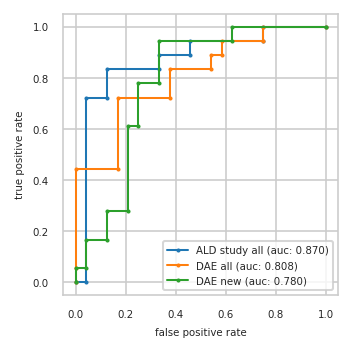

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.000 0.056
2          0.042 0.722   0.000 0.444   0.042 0.056
3          0.125 0.722   0.167 0.444   0.042 0.167
4          0.125 0.833   0.167 0.722   0.125 0.167
5          0.333 0.833   0.375 0.722   0.125 0.278
6          0.333 0.889   0.375 0.833   0.208 0.278
7          0.458 0.889   0.542 0.833   0.208 0.611
8          0.458 0.944   0.542 0.889   0.250 0.611
9          0.750 0.944   0.583 0.889   0.250 0.778
10         0.750 1.000   0.583 0.944   0.333 0.778
11         1.000 1.000   0.750 0.944   0.333 0.944
12           NaN   NaN   0.750 1.000   0.625 0.944
13           NaN   NaN   1.000 1.000   0.625 1.000
14           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P02741,Q99983,P43004;P43004-2;P43004-3
2,Q9P2E7;Q9P2E7-2,Q8NFY4;Q8NFY4-6,P51688
3,P61981,P09104,P31321
4,Q99983,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
5,P04075,Q9Y2T3;Q9Y2T3-3,Q8TEA8
6,P14174,P14174,O95497
7,None,Q14894,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
8,None,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


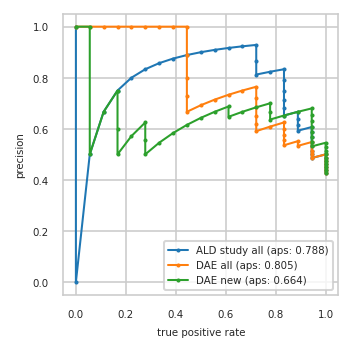

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.486 0.944     0.514 1.000
8          0.500 0.944     0.500 0.944     0.529 1.000
9          0.515 0.944     0.515 0.944     0.545 1.000
10         0.531 0.944     0.531 0.944     0.531 0.944
11         0.548 0.944     0.548 0.944     0.548 0.944
12         0.567 0.944     0.533 0.889     0.567 0.944
13         0.586 0.944     0.552 0.889     0.586 0.944
14         0.607 0.944     0.536 0.833     0.607 0.944
15         0.593 0.889     0.556 0.833     0.630 0.944
16         0.615 0.889     0.577 0.833     0.654 0.944
17         0.640 0.889     0.600 0.833     0.680 0.944
18         0.667 0.889     0.625 0.833     0.667 0.889
19         0.652 0.833     0.609 0.778     0.652 0.833
20         0.682 0.833     0.591 0.722     0.636 0.778
21         0.714 0.833     0.619 0.722     0.667 0.778
22         0.750 0.833     0.650 0.722     0.700 0.778
23         0.789 0.833     0.684 0.722     0.684 0.722
24         0.833 0.833     0.722 0.722     0.667 0.667
25         0.824 0.778     0.765 0.722     0.647 0.611
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.867 0.722     0.733 0.611     0.667 0.556
28         0.929 0.722     0.714 0.556     0.643 0.500
29         0.923 0.667     0.692 0.500     0.615 0.444
30         0.917 0.611     0.667 0.444     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     1.000 0.444     0.625 0.278
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


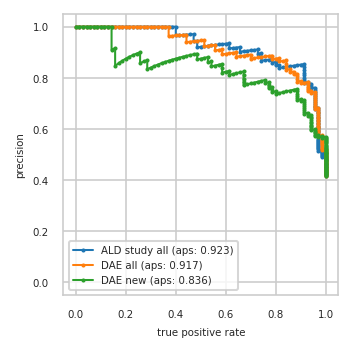

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


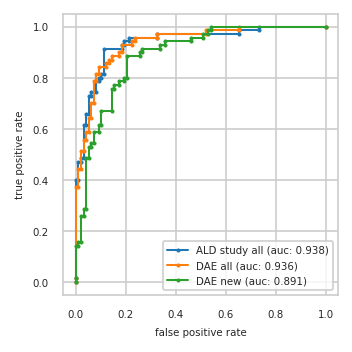

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}